## Predicting Bike Rental Station Traffic

#### TODO:
- group stations in some way
- get an lstm working
- try many predict one first, then many predict many (maybe 12-24 hours)
- try out a gru/different architectures, cv
- see if more than one year helps
- include weather
- scale up, get one model for one station for many stations (all if possible)
- flask basic
- flask interactive
- repo writeup (requirements/put authorship in py/slice of data)

#### future:
- group stations (takes into account nearby traffic) like RNN that has more than one station's output
- live feed: https://gbfs.divvybikes.com/gbfs/gbfs.json

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from geopy.distance import geodesic

In [2]:
def basic_dist(row):
    # Gives a basic euclidean trip distance in m
    
    if row['round_trip'] == 1:
        return 0
    
    a = (row['start_lat'], row['start_lng'])
    
    b = (row['end_lat'], row['end_lng'])
    
    return geodesic(a, b).km * 1000

In [267]:
def station_data(region=None, eda=False):
    '''Loads, preps, and filters data for machine learning'''
    
    # Gather one years worth of data
    filelist = []
    frames = []
    
    for month in [4,5,6,7,8,9,10,11,12]:
        filelist.append('data/2020{:02d}-divvy-tripdata.csv'.format(month))
    for month in [1,2,3]:
        filelist.append('data/2021{:02d}-divvy-tripdata.csv'.format(month))
    
    usecols = ['started_at', 'ended_at', 'start_station_name', 'end_station_name', 'member_casual', 'rideable_type',
               'start_lat', 'start_lng', 'end_lat', 'end_lng']
    
    for month in filelist:
        lil_df = pd.read_csv(month, usecols=usecols)
        
        if region is not None:
            # filter for specific station
            mask1 = (lil_df['end_station_name'].isin(region))
            mask2 = (lil_df['start_station_name'].isin(region))
            mask = mask1 | mask2

            lil_df = lil_df[mask]
        
        frames.append(lil_df)

    df = pd.concat(frames, ignore_index=True)
    
    # Only relevant missing data is lat/long, warns us if ever dropping more than 1%
    allrows = df.shape[0]
    
    df = df[df['start_lat'].notna()]
    df = df[df['end_lat'].notna()]
    if allrows/df.shape[0] > 1.01:
        print('NULL WARNING: more than 1% of rows null')

    df = df.reset_index(drop=True)

    # prepping for machine learning
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    df['started_at'] = pd.to_datetime(df['started_at'])

    df['date'] = pd.to_datetime(df['ended_at']).dt.date
    df['hour'] = df['ended_at'].dt.hour
    
    # For some reason each month has a few trips from the upcoming month
    # change this date if you want to use newer data
    df = df[df['date'] < pd.to_datetime('2021-04-01')]
    
    # keep all hours for eda, otherwise only use 9am to 8pm (12 hours)
    if eda == False:
        df = df[df['hour'] <= 20]
        df = df[df['hour'] >= 9]

    # daylight savings makes a few negative trip times, a quick approximate fix is okay
    df['trip_time'] = abs((df['ended_at'] - df['started_at']).dt.total_seconds())

    df['round_trip'] = df.apply(lambda x: 1 if x['start_station_name'] == x['end_station_name'] else 0, axis=1)

    df['electric'] = df['rideable_type'].apply(lambda x: 1 if x == 'electric_bike' else 0)

    df['member'] = df['member_casual'].apply(lambda x: 1 if x == 'member' else 0)
    
    # 1 if bike is coming to station, 0 if leaving. Hopefully useful for ratios
    df['entering'] = df['end_station_name'].apply(lambda x: 1 if x in region else 0)

    # takes time but is more accurate and in meters. Can convert to euclidean coord dist to save time
    '''UNCOMMENT THIS LATER'''
    df['trip_dist'] = df.apply(basic_dist, axis=1)
    
    dropcols = ['rideable_type', 'member_casual', 'started_at', 'ended_at',
                'start_lat', 'start_lng', 'end_lat', 'end_lng']
    
    if region is not None:
        dropcols.append('start_station_name')
        dropcols.append('end_station_name')
    
    df = df.drop(columns=dropcols)
    
    # drop rows that leaked in from past march 2021 (who put them there?)

    return df

## EDA

In [79]:
df35 = station_data(35)

df35

,date,hour,trip_time,round_trip,electric,member,entering,trip_dist
35,,,,,,,,
0,2020-04-30,18,324.0,0,0,1,1,953.433498
1,2020-04-02,14,313.0,0,0,1,0,771.019785
2,2020-04-05,18,4065.0,0,0,0,1,3204.948053
3,2020-04-25,18,1760.0,0,0,1,1,2523.817732
4,2020-04-07,19,1994.0,0,0,1,1,2825.757522
...,...,...,...,...,...,...,...,...
60587,2020-11-28,14,2177.0,0,0,0,1,5838.540699
60589,2020-11-07,13,2177.0,0,0,0,1,4913.115625
60590,2020-11-07,16,1667.0,0,0,0,1,4256.160320


In [80]:
df35.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55802 entries, 0 to 60592
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        55802 non-null  datetime64[ns]
 1   hour        55802 non-null  int64         
 2   trip_time   55802 non-null  float64       
 3   round_trip  55802 non-null  int64         
 4   electric    55802 non-null  int64         
 5   member      55802 non-null  int64         
 6   entering    55802 non-null  int64         
 7   trip_dist   55802 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 3.8 MB


In [89]:
df35a = df35.groupby(['date', 'hour']).agg('mean')

df35a['size'] = df35.groupby(['date', 'hour']).size()

df35a

trip_time  round_trip  electric  member  entering  \
date       hour                                                      
2020-04-01 11       2566.0         0.0       0.0     1.0       1.0   
           16        233.0         0.0       0.0     1.0       0.0   
2020-04-02 9         366.0         0.0       0.0     1.0       0.0   
           13       3312.0         0.0       0.0     1.0       0.0   
           14        313.0         0.0       0.0     1.0       0.0   
...                    ...         ...       ...     ...       ...   
2020-11-30 12       1263.0         0.0       1.0     1.0       1.0   
           14       1628.5         0.0       0.0     0.0       1.0   
           16        179.0         0.0       1.0     1.0       1.0   
           18       1725.0         0.0       0.0     1.0       0.0   
           21        752.0         0.0       0.0     1.0       1.0   

                   trip_dist  size  
date       hour                     
2020-04-01 11    5627.490317     1  
           16     771.019785     1  
2020-04-02 9      771.019785     1  
           13    1717.595674     1  
           14     771.019785     1  
...                      ...   ...  
2020-11-30 12    2844.798866     1  
           14    1043.273717     2  
           16     776.745231     1  
           18    3959.468087     1  
           21    2069.734803     1  

[2551 rows x 7 columns]

In [29]:
df35b = df35.groupby(['hour']).agg(['sum', 'count'])

df35b

trip_time       round_trip       electric       member       entering  \
             sum count        sum count      sum count    sum count      sum   
hour                                                                           
0      1574567.0   452        117   452       16   452     32   452      252   
1       888441.0   193         62   193       11   193     19   193      115   
2       556132.0   120         37   120        7   120     12   120       64   
3       602481.0   101         38   101        3   101      2   101       54   
4       158673.0    36         11    36        1    36      4    36       22   
5       432839.0    72          6    72        1    72     33    72       58   
6      1286700.0   339         22   339       19   339    228   339      237   
7      2103544.0   684         76   684       59   684    486   684      321   
8      2062494.0   827         62   827       67   827    623   827      347   
9      2665555.0  1018         89  1018       98  1018    532  1018      600   
10     4220064.0  1652        147  1652      169  1652    632  1652     1042   
11     6688837.0  2839        228  2839      203  2839    832  2839     1887   
12     9423535.0  3827        275  3827      294  3827    901  3827     2375   
13    11458695.0  4740        382  4740      350  4740   1042  4740     3011   
14    13922259.0  5500        494  5500      325  5500   1114  5500     3248   
15    17691797.0  5927        612  5927      372  5927   1168  5927     3525   
16    15937051.0  6365        601  6365      392  6365   1290  6365     3617   
17    15623021.0  6426        624  6426      373  6426   1629  6426     3653   
18    14209080.0  6126        705  6126      379  6126   1674  6126     3511   
19    12189700.0  5023        543  5023      231  5023   1422  5023     2714   
20     9957053.0  3886        529  3886      134  3886    930  3886     1962   
21     8099775.0  2473        377  2473       87  2473    429  2473     1079   
22     4008459.0  1295        203  1295       50  1295    175  1295      555   
23     2270394.0   672        143   672       22   672     89   672      317   

            
     count  
hour        
0      452  
1      193  
2      120  
3      101  
4       36  
5       72  
6      339  
7      684  
8      827  
9     1018  
10    1652  
11    2839  
12    3827  
13    4740  
14    5500  
15    5927  
16    6365  
17    6426  
18    6126  
19    5023  
20    3886  
21    2473  
22    1295  
23     672

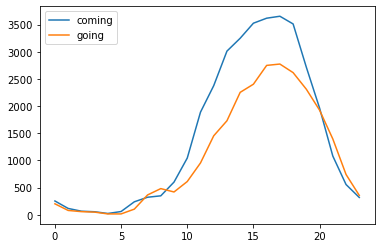

In [35]:
# make this into a function later

# ratio of coming / going per hour, uses agg mean
fig, ax = plt.subplots()

ax.plot(df35b.index, df35b['entering', 'sum'], label='coming')
ax.plot(df35b.index, df35b['entering', 'count'] - df35b['entering', 'sum'], label='going')
ax.legend();

## groups
loosely based off this map: https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations-All-Map/bk89-9dk7

In [152]:
# Downtown
group_a = set([92,146,47,217,285,31,119,191,286,21,53,125,32,173,96,6,181,
           39,77,33,7,196,86,81,638,110,24,627,107,109,277,212,198,
           264,45,2,89,84,75,98,211,337,164,37,161,25,672,195,43,636,
           36,142,197,350,175,169,26,35,111,66,215,192,635,56,18,74,
           122,100,233,76,624,199,631,5,73,174,80,38,186,383,106,194,
           40,621,52,48,99,346,51,91,284,68,88,49,134,90,44,54,71,112,
           283,623,287,133,50,637,654])

len(group_a)

107

In [153]:
# Lincoln park
group_b = set([127,163,327,131,188,349,288,177,223,162,157,319,67,87,143,
           154,226,220,302,153,505,141,34,58,115,310,228,300,332,219,
           258,144,329,250,94,166,340,307,156,324,296,334,13,504,313,
           309,225,673,190,152,117,113,343,664])

len(group_b)

54

In [154]:
# Wicker park
group_c = set([666,92,69,158,224,365,511,506,86,276,183,213,216,510,305,
           622,128,58,331,130,659,20,315,61,219,17,509,16,508,350,93,
           657,30,374,29,159,160,210,628,60,373,116,333,54,641,637,643,
           658])

len(group_c)

48

In [155]:
# Hyde park
group_d = set([12,564,567,121,431,561,426,101,418,345,559,11,565,569,398,
           568,388,652,328,393,248,560,572,428,562,385,102,95,355,653,
           427,392,395,415,247,555,386,400,421,422,556,399,351,423,
           420,575,557,424,593,570,391,647,356,396,384,430,352,571,554,
           563,390,425,429,270,322,558,417,204,419,649,650,674,646,648,
           678,679])

len(group_d)

76

In [156]:
# Uptown
group_e = set([245,481,478,234,240,312,292,475,311,463,238,465,471,316,
           231,472,326,486,243,297,253,246,314,298,249,306,323,295,
           318,239,325,242,251,244,256,476,477,639,254,480,293,464,
           482,344])

len(group_e)

44

In [157]:
# Chinatown
group_f = set([402,62,403,272,132,280,401,120,339,406,207,171,370,148,147,
           237,193,4,135,184,206,42,366,209,335,150,208,368,263,149])

len(group_f)

30

In [259]:
def serialize(inputdf):
    '''finish later'''
    
    out = inputdf.groupby(['date', 'hour']).agg('mean')
    
    out['size'] = inputdf.groupby(['date', 'hour']).size()
    
    dti = pd.Series(pd.date_range("2020-04-01", freq="D", periods=365)).dt.date

    idx = pd.MultiIndex.from_product([dti, [9,10,11,12,13,14,15,16,17,18,19,20]], names=['date', 'hour'])

    df_blank = pd.DataFrame(data = np.zeros(shape=(365*12, 7)), index=idx,
                            columns=['trip_time', 'round_trip', 'electric', 'member', 'entering', 
                                     'trip_dist', 'size'])

    return pd.concat([df_blank, out]).groupby(['date', 'hour']).agg('sum')

In [116]:
dfall

,start_station_id,end_station_id,date,hour,trip_time,round_trip,electric,member,entering,trip_dist
0,86,152.0,2020-04-26,18,1609.0,0,0,1,0,3981.345842
1,503,499.0,2020-04-17,17,489.0,0,0,1,0,979.629317
2,142,255.0,2020-04-01,18,863.0,0,0,1,0,2984.661192
3,216,657.0,2020-04-07,13,732.0,0,0,1,0,2141.374633
4,125,323.0,2020-04-18,11,3175.0,0,0,0,0,9119.684872
...,...,...,...,...,...,...,...,...,...,...
3485005,13042,TA1306000013,2021-03-20,17,8631.0,0,0,0,0,1202.115491
3485006,KA1503000043,TA1306000013,2021-03-02,11,507.0,0,0,1,0,1661.041299
3485007,13042,KA1504000146,2021-03-09,11,2495.0,0,0,1,0,9310.940595
3485008,KA1503000043,TA1306000013,2021-03-01,18,400.0,0,0,1,0,1661.041299


In [142]:
# raw data for whatever you might need it for
filelist = []
frames = []

for month in [4,5,6,7,8,9,10,11,12]:
    filelist.append('data/2020{:02d}-divvy-tripdata.csv'.format(month))
for month in [1,2,3]:
    filelist.append('data/2021{:02d}-divvy-tripdata.csv'.format(month))

for month in filelist:
    lil_df = pd.read_csv(month)

    frames.append(lil_df)

dfraw = pd.concat(frames, ignore_index=True)

dfraw

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,A847FADBBC638E45,docked_bike,2020-04-26 17:45:14,2020-04-26 18:12:03,Eckhart Park,86,Lincoln Ave & Diversey Pkwy,152.0,41.896400,-87.661000,41.932200,-87.658600,member
1,5405B80E996FF60D,docked_bike,2020-04-17 17:08:54,2020-04-17 17:17:03,Drake Ave & Fullerton Ave,503,Kosciuszko Park,499.0,41.924400,-87.715400,41.930600,-87.723800,member
2,5DD24A79A4E006F4,docked_bike,2020-04-01 17:54:13,2020-04-01 18:08:36,McClurg Ct & Erie St,142,Indiana Ave & Roosevelt Rd,255.0,41.894500,-87.617900,41.867900,-87.623000,member
3,2A59BBDF5CDBA725,docked_bike,2020-04-07 12:50:19,2020-04-07 13:02:31,California Ave & Division St,216,Wood St & Augusta Blvd,657.0,41.903000,-87.697500,41.899200,-87.672200,member
4,27AD306C119C6158,docked_bike,2020-04-18 10:22:59,2020-04-18 11:15:54,Rush St & Hubbard St,125,Sheridan Rd & Lawrence Ave,323.0,41.890200,-87.626200,41.969500,-87.654700,casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3489743,9397BDD14798A1BA,docked_bike,2021-03-20 14:58:56,2021-03-20 17:22:47,Michigan Ave & Oak St,13042,New St & Illinois St,TA1306000013,41.900960,-87.623777,41.890847,-87.618617,casual
3489744,BBBEB8D51AAD40DA,classic_bike,2021-03-02 11:35:10,2021-03-02 11:43:37,Kingsbury St & Kinzie St,KA1503000043,New St & Illinois St,TA1306000013,41.889177,-87.638506,41.890847,-87.618617,member
3489745,637FF754DA0BD9E1,classic_bike,2021-03-09 11:07:36,2021-03-09 11:49:11,Michigan Ave & Oak St,13042,Clark St & Berwyn Ave,KA1504000146,41.900960,-87.623777,41.977997,-87.668047,member
3489746,F8F43A0B978A7A35,classic_bike,2021-03-01 18:11:57,2021-03-01 18:18:37,Kingsbury St & Kinzie St,KA1503000043,New St & Illinois St,TA1306000013,41.889177,-87.638506,41.890847,-87.618617,member


In [167]:
group_f2 = []

for stationid in group_f:

    name = dfraw[dfraw['end_station_id'] == stationid]
    
    if len(name) == 0:
        print('no ', stationid)
    else:
        group_f2.append(name.iloc[0]['end_station_name'])

    df_f = pd.DataFrame(group_f2, columns=['name'])

    df_f['group'] = 'f'

df_f

,name,group
0,Wentworth Ave & 24th St (Temp),f
1,Burnham Harbor,f
2,Halsted St & 21st St,f
3,Rhodes Ave & 32nd St,f
4,Indiana Ave & 31st St,f
5,Shields Ave & 28th Pl,f
6,Shields Ave & 31st St,f
7,Wentworth Ave & 33rd St,f
8,State St & 33rd St,f
9,Indiana Ave & 26th St,f


In [168]:
groups = pd.concat([df_a, df_b, df_c, df_d, df_e, df_f])

## post-processing eda

In [183]:
# how to get the station names for each group
# a: downtown, b: lincoln park, c: wicker park, d: hyde park, e: uptown, f: chinatown

groups = pd.read_csv('data/groups.csv')

downtown = set(groups[groups['group'] == 'a'].name.values)

In [272]:
df_down = station_data(region=downtown)

df_down

,date,hour,trip_time,round_trip,electric,member,entering,trip_dist
0,2020-04-26,18,1609.0,0,0,1,0,3981.345842
1,2020-04-01,18,863.0,0,0,1,0,2984.661192
2,2020-04-18,11,3175.0,0,0,0,0,9119.684872
3,2020-04-30,18,324.0,0,0,1,1,953.433498
4,2020-04-02,14,313.0,0,0,1,1,771.019785
...,...,...,...,...,...,...,...,...
1463252,2021-03-21,20,251.0,0,0,1,1,390.067308
1463253,2021-03-21,17,444.0,0,1,1,1,826.411494
1463254,2021-03-06,12,3711.0,0,0,0,0,10165.091436
1463255,2021-03-02,11,507.0,0,0,1,0,1661.041299


In [273]:
df_down_1 = serialize(df_down)

In [274]:
# why are three days missing?
df_down_1[df_down_1['size'] == 0]

trip_time  round_trip  electric  member  entering  trip_dist  \
date       hour                                                                 
2020-05-31 9           0.0         0.0       0.0     0.0       0.0        0.0   
           10          0.0         0.0       0.0     0.0       0.0        0.0   
           11          0.0         0.0       0.0     0.0       0.0        0.0   
           12          0.0         0.0       0.0     0.0       0.0        0.0   
           13          0.0         0.0       0.0     0.0       0.0        0.0   
           14          0.0         0.0       0.0     0.0       0.0        0.0   
           15          0.0         0.0       0.0     0.0       0.0        0.0   
           16          0.0         0.0       0.0     0.0       0.0        0.0   
           17          0.0         0.0       0.0     0.0       0.0        0.0   
           18          0.0         0.0       0.0     0.0       0.0        0.0   
           19          0.0         0.0       0.0     0.0       0.0        0.0   
           20          0.0         0.0       0.0     0.0       0.0        0.0   
2020-06-01 9           0.0         0.0       0.0     0.0       0.0        0.0   
           10          0.0         0.0       0.0     0.0       0.0        0.0   
           11          0.0         0.0       0.0     0.0       0.0        0.0   
           12          0.0         0.0       0.0     0.0       0.0        0.0   
           13          0.0         0.0       0.0     0.0       0.0        0.0   
           14          0.0         0.0       0.0     0.0       0.0        0.0   
           15          0.0         0.0       0.0     0.0       0.0        0.0   
           16          0.0         0.0       0.0     0.0       0.0        0.0   
           17          0.0         0.0       0.0     0.0       0.0        0.0   
           18          0.0         0.0       0.0     0.0       0.0        0.0   
           19          0.0         0.0       0.0     0.0       0.0        0.0   
           20          0.0         0.0       0.0     0.0       0.0        0.0   
2020-06-02 9           0.0         0.0       0.0     0.0       0.0        0.0   
           10          0.0         0.0       0.0     0.0       0.0        0.0   
           11          0.0         0.0       0.0     0.0       0.0        0.0   
           12          0.0         0.0       0.0     0.0       0.0        0.0   
           13          0.0         0.0       0.0     0.0       0.0        0.0   
           14          0.0         0.0       0.0     0.0       0.0        0.0   
           15          0.0         0.0       0.0     0.0       0.0        0.0   
           16          0.0         0.0       0.0     0.0       0.0        0.0   
           17          0.0         0.0       0.0     0.0       0.0        0.0   
           18          0.0         0.0       0.0     0.0       0.0        0.0   
           19          0.0         0.0       0.0     0.0       0.0        0.0   
           20          0.0         0.0       0.0     0.0       0.0        0.0   

                 size  
date       hour        
2020-05-31 9      0.0  
           10     0.0  
           11     0.0  
           12     0.0  
           13     0.0  
           14     0.0  
           15     0.0  
           16     0.0  
           17     0.0  
           18     0.0  
           19     0.0  
           20     0.0  
2020-06-01 9      0.0  
           10     0.0  
           11     0.0  
           12     0.0  
           13     0.0  
           14     0.0  
           15     0.0  
           16     0.0  
           17     0.0  
           18     0.0  
           19     0.0  
           20     0.0  
2020-06-02 9      0.0  
           10     0.0  
           11     0.0  
           12     0.0  
           13     0.0  
           14     0.0  
           15     0.0  
           16     0.0  
           17     0.0  
           18     0.0  
           19     0.0  
           20     0.0

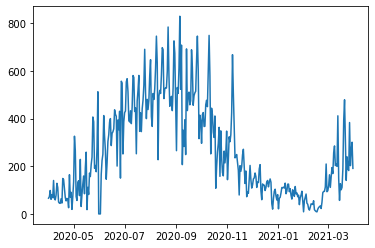

In [281]:
graph = df_down_1.groupby(level=0).mean()['size']

fig, ax = plt.subplots()

ax.plot(graph.index, graph)